### **Download Resources and Model**

In [1]:
!pip install -qq ftfy regex tqdm
!pip install -qq transformers
!pip install wandb -qU
!pip install -qq evaluate
!pip install -qq pytorch-lightning==1.9.0
!pip install -qq torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.0/254.0 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 17.9 MB/s eta 0:00:00


In [2]:
# Log in to Wandb account
# Code to prevent wandb from crashing Colab
import wandb
import sys

def wandb_colab_login():
  """Temporary hack to prevent colab from hanging"""
  sys.modules["google.colab2"] = sys.modules["google.colab"]
  del sys.modules["google.colab"]
  wandb.login(key="<YOUR_API_KEY>")
  sys.modules["google.colab"] = sys.modules["google.colab2"]
wandb_colab_login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
from transformers import AdamW, get_linear_schedule_with_warmup

In [4]:
%matplotlib inline

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os

**Define Base Models**

In [5]:
from transformers import AutoTokenizer, OPTForCausalLM


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m")
opt_model = OPTForCausalLM.from_pretrained("facebook/opt-125m")

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [6]:
from transformers import ConvNextModel, ConvNextFeatureExtractor

convNext_model = ConvNextModel.from_pretrained("facebook/convnext-base-224-22k-1k")

image_processor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-base-224-22k-1k")

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


### **Amazon Dataset**

Download CSV and images

In [7]:
!wget -q -O images.zip https://comp576-image-data.s3.us-east-2.amazonaws.com/image.zip
!unzip -qq images.zip

In [8]:
!wget -q -O text.csv https://raw.githubusercontent.com/littlehongman/Comp576-Group41-Image-Captioning/main/Amazon_cleaned.csv

In [9]:
import torchtext
import pandas as pd
import random
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence


random.seed(42)

class AmazonDataset(Dataset):
    def __init__(self, tokenizer,
                 split: str, # train, val
                 max_length: int,
                 df, # Pandas dataframe
                 text_type,
                 image_dir = "/content/image",
                 image_transform = None):

        assert split in ['val', 'train'], 'invalid split'
        assert text_type in ['product_name', 'review_content'], 'invalid split'

        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.split = split
        self.max_length = max_length
        self.image_dir = image_dir


        # Get list of indices of (img, caption) pair
        # self.indices = df['index'].tolist()

        self.indices = df['index'].tolist()


        # Tokenize and add examples to the local variables.
        self.tokenized_texts = list()
        self.images = list()

        for idx, img_idx in enumerate(self.indices):
            # Load and tokenize text
            text = df.iloc[idx][text_type]

            encoded_text = self.tokenizer.encode_plus(
                text, add_special_tokens = True, truncation = True,
                max_length = max_length, padding = 'max_length',
                return_attention_mask = True, return_tensors = 'pt')

            self.tokenized_texts.append(encoded_text)

            # Save image filename
            self.images.append(f"{img_idx}.jpg")


    def __len__(self):
        return len(self.tokenized_texts)

    def __getitem__(self, i):
        text = self.tokenized_texts[i]['input_ids'][0]
        text_mask = self.tokenized_texts[i]['attention_mask'][0]

        # Load the image
        image = Image.open(os.path.join(f"{self.image_dir}/", self.images[i])).convert("RGB")

        if self.image_transform:
            # AutoProcessor transform will return extra dimension
            image = self.image_transform(image, return_tensors="pt").pixel_values[0]

        # Preprend extra mask for the encoder embedding
        image_embedding_mask = torch.ones(self.max_length)
        text_mask = torch.concat((image_embedding_mask, text_mask), -1)

        return image, text, text_mask


**Shuffle the Pandas Dataframe**

In [10]:
text_type = "product_name"
text_dir = "/content/text.csv"


# Read the text csv file using pandas
df = pd.read_csv(text_dir)

# Remove nan
df = df[df[text_type].notna()]

# Random Split
df_train = df.sample(frac=0.9,random_state=200)
df_test = df.drop(df_train.index)

In [11]:
max_length = 20

trainset = AmazonDataset(tokenizer, 'train', max_length, df_train, text_type,
                             image_transform = image_processor)

valset = AmazonDataset(tokenizer, 'val', max_length, df_test, text_type,
                             image_transform = image_processor)

In [12]:
testset = AmazonDataset(tokenizer, 'val', max_length, df_test, text_type,
                             image_transform = None)

In [13]:
import multiprocessing

cores = multiprocessing.cpu_count()

train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size = 8,
                                           num_workers = cores // 2,
                                           shuffle = True,
                                           pin_memory=False)

val_loader = torch.utils.data.DataLoader(valset,
                                           batch_size = 8,
                                           num_workers = cores // 2,
                                           shuffle = False,
                                          pin_memory=False)

### **Define Model**

#### **Create the ImageEncoder**

In [14]:
class ImageEncoder(nn.Module):

    def __init__(self, base_network):
        super(ImageEncoder, self).__init__()
        self.base_network = base_network
        self.embedding_size = 1024

    def forward(self, images):
        with torch.no_grad():
            x = self.base_network(pixel_values=images).pooler_output
            x = F.normalize(x, dim=-1)
            x = x.float()

        return x

#### **Create the Mapping Network**

In [15]:
class Mapping(nn.Module):
    def __init__(self, encoder_embedding_size, decoder_embedding_size, length=20):
        super(Mapping, self).__init__()

        self.encoder_embedding_size = encoder_embedding_size
        self.decoder_embedding_size = decoder_embedding_size
        self.length = length

        self.fc1 = nn.Linear(encoder_embedding_size, decoder_embedding_size * length)

    def forward(self, x):
        x = self.fc1(x)

        return x.view(-1, self.length, self.decoder_embedding_size)

#### **Create the TextDecoder Network**

In [16]:
class TextDecoder(nn.Module):
    def __init__(self, base_network):
        super(TextDecoder, self).__init__()
        self.base_network = base_network

        self.embedding_size = self.base_network.model.decoder.embed_tokens.embedding_dim
        self.vocab_size = self.base_network.model.decoder.embed_tokens.num_embeddings

    def forward(self, concat_embedding, mask=None):
        return self.base_network(inputs_embeds=concat_embedding, attention_mask=mask)


    def get_embedding(self, texts):
        return self.base_network.model.decoder.embed_tokens(texts)

#### **Create the ImageCaptioner Network**

In [17]:
from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):
    def __init__(self, stops = [], encounters=1):
        super().__init__()
        self.stops = [stop.to("cuda") for stop in stops]

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_token = input_ids[0][-1]
        for stop in self.stops:
            if tokenizer.decode(stop) == tokenizer.decode(last_token):
                return True
        return False

In [18]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics import BLEUScore
import evaluate

class ImageCaptioner(pl.LightningModule):
    def __init__(self, encoder, decoder, tokenizer, total_steps, temperature=0.9, max_length=20):
        super(ImageCaptioner, self).__init__()

        self.padding_token_id = tokenizer.pad_token_id
        #self.stop_token_id = tokenizer.encode('.')[0]

        # Define networks
        self.encoder = ImageEncoder(encoder)
        self.decoder = TextDecoder(decoder)
        self.mapping_network = Mapping(self.encoder.embedding_size, self.decoder.embedding_size, max_length)

        # Define variables
        self.temperature = temperature
        self.total_steps = total_steps
        self.max_length = max_length
        self.encoder_embedding_size = self.encoder.embedding_size
        self.decoder_embedding_size = self.decoder.embedding_size
        self.decoder_vocab_size = self.decoder.vocab_size

        # Define loss function
        self.criterion = nn.CrossEntropyLoss(ignore_index = self.padding_token_id)

        # Define stopping criteria
        stop_words = ["."]
        stop_words_ids = [tokenizer(stop_word, return_tensors='pt', add_special_tokens=False)['input_ids'].squeeze() for stop_word in stop_words]
        self.stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])

        # Define learning rate
        self.mapping_lr = 1e-3
        self.decoder_lr = 2e-5

        # Metrics Helpers
        self.rouge = ROUGEScore()
        self.meteor = evaluate.load('meteor')
        self.bleu = BLEUScore(n_gram=1)

        self.save_hyperparameters()

    def forward(self, images, texts, masks):
        texts_embedding = self.decoder.get_embedding(texts)
        images_embedding = self.encoder(images)

        images_projection = self.mapping_network(images_embedding).view(-1, self.max_length, self.decoder_embedding_size)
        embedding_concat = torch.cat((images_projection, texts_embedding), dim=1)

        out = self.decoder(embedding_concat, masks)

        return out

    def predict(self, images):
        model.eval()

        output_ids = []

        with torch.no_grad():
            images_embedding = self.encoder(images)
            images_projection = model.mapping_network(images_embedding).view(-1, self.max_length, self.decoder_embedding_size)

            input_state = images_projection

            output_ids = model.decoder.base_network.generate(inputs_embeds=images_projection,
                                pad_token_id=tokenizer.eos_token_id,
                                max_new_tokens=self.max_length,
                                num_beams=5,
                                temperature=self.temperature,
                                do_sample=True,
                                penalty_alpha=0.7,
                                no_repeat_ngram_size=1,
                                repetition_penalty=1.1,
                                stopping_criteria=self.stopping_criteria)

        return output_ids

    def training_step(self, batch, batch_idx, optimizer_idx):
        images, texts, masks = batch

        outputs = model(images, texts, masks).logits

        loss = self.criterion(outputs[:, self.max_length - 1: -1].reshape(-1, self.decoder_vocab_size), texts.reshape(-1))

        return loss

    def validation_step(self, batch, batch_idx):
        images, texts, masks = batch

        # Get Loss
        outputs = model(images, texts, masks).logits

        loss = self.criterion(outputs[:, self.max_length - 1: -1].reshape(-1, self.decoder_vocab_size), texts.reshape(-1))

        # Get Scores
        output_ids = self.predict(images).cpu().tolist()
        rouge_score, meteor_score, bleu_score = self.calculate_metrics(output_ids, texts)


        # Use this line, to be read at model checkpoint
        self.log('val/val_loss', loss, on_epoch = True)

        return {'val_loss': loss, 'rouge': rouge_score, 'meteor': meteor_score, 'bleu': bleu_score}

    def calculate_metrics(self, preds, texts):
        targets = texts.cpu()

        total_rouge_scores = 0.0
        total_meteor_scores = 0.0
        total_bleu_scores = 0.0

        for pred, target in zip(preds, targets):
            # truncate to the stop token
            try:
                stop_idx = pred.index(self.padding_token_id)
            except:
                stop_idx = len(pred)

            sentence = tokenizer.decode(pred[:stop_idx])
            target = tokenizer.decode(target, skip_special_tokens=True)

            # ROGUE
            rouge_score = self.rouge(sentence, target)
            total_rouge_scores += rouge_score['rougeL_fmeasure']

            # METEOR
            meteor_score = self.meteor.compute(predictions=[sentence], references=[target])
            total_meteor_scores += torch.tensor(meteor_score['meteor'])

            # BLEU
            bleu_score = self.bleu([sentence], [[target]])
            total_bleu_scores += bleu_score

        return total_rouge_scores / len(preds), total_meteor_scores / len(preds), total_bleu_scores / len(preds)


    def training_epoch_end(self, outputs):
        loss_mean = torch.stack([x['loss'] for x in outputs[0]]).mean()

        print('Epoch {} Training loss: {:.2f}'.format(self.current_epoch, loss_mean))

        # Log training loss
        self.log('train/train_loss', loss_mean)


    def validation_epoch_end(self, outputs):
        loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        rouge_mean = torch.stack([x['rouge'] for x in outputs]).mean()
        meteor_mean = torch.stack([x['meteor'] for x in outputs]).mean()
        bleu_mean = torch.stack([x['bleu'] for x in outputs]).mean()

        print('Epoch {} Validation loss: {:.2f}'.format(self.current_epoch, loss_mean))
        print('Epoch {} Rouge score: {:.2f}'.format(self.current_epoch, rouge_mean * 100))
        print('Epoch {} Meteor score: {:.2f}'.format(self.current_epoch, meteor_mean * 100))
        print('Epoch {} Bleu score: {:.2f}'.format(self.current_epoch, bleu_mean * 100))

        # Log validation loss, rogue
        self.log('val/val_loss', loss_mean)
        self.log('val/val_rouge', rouge_mean)
        self.log('val/val_meteor', meteor_mean)
        self.log('val/val_bleu', bleu_mean)

        # Log for checkpoint
        self.log('val_loss', loss_mean)
        self.log('val_metric_mean', (rouge_mean + meteor_mean + bleu_mean) / 3)

        return {'val_loss': loss_mean}


    def configure_optimizers(self):
        decoder_optimizer = torch.optim.AdamW(self.decoder.parameters(), lr = self.decoder_lr)
        scheduler = get_linear_schedule_with_warmup(decoder_optimizer,
                                            num_warmup_steps = 5000,
                                            num_training_steps = self.total_steps)


        return [torch.optim.Adam(self.mapping_network.parameters(), lr = self.mapping_lr), decoder_optimizer], [scheduler]

### **Train model**

**(Optional)** Load previous model

In [ ]:
# run = wandb.init(entity='hungchiehwu', project='ConvNEXT-GPT2-COCO-amazon-name-v4', reinit=True)
# artifact = run.use_artifact('hungchiehwu/ConvNEXT-OPT-125m-amazon-name-v4/model-1xzkjuw6:v0', type='model')
# artifact_dir = artifact.download()

# model = ImageCaptioner(image_encoder_model, gpt_model, tokenizer, 0)
# checkpoint = torch.load(f"{artifact_dir}/model.ckpt")
# model.load_state_dict(checkpoint["state_dict"])

In [ ]:
num_epoch = 20
total_steps = len(train_loader) * num_epoch

# Create model
model = ImageCaptioner(convNext_model, opt_model, tokenizer, total_steps)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `BLEUScore` from `torchmetrics` was deprecated and will be removed in 2.0. Import `BLEUScore` from `torchmetrics.text` instead.
  _future_warning(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them us

In [ ]:
from pytorch_lightning.loggers import WandbLogger

wandb.init(entity='hungchiehwu', project='ConvNEXT-OPT-125m-amazon-name-v4', reinit=True)
wandb_logger = WandbLogger(log_model=True)

wandb: Currently logged in as: hungchiehwu. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filename = 'checkpoints/image_caption_weights_{epoch:03d}-{val_loss:.2f}',
    verbose = True, monitor = 'val_metric_mean', mode = 'max', save_top_k = 1)


trainer = pl.Trainer(accelerator="gpu", devices=1,
                     max_epochs=num_epoch,
                     callbacks = [checkpoint_callback],
                     enable_model_summary=True,
                     logger=wandb_logger
                     )

trainer.fit(model,
            train_dataloaders = train_loader,
            val_dataloaders = [val_loader])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params
-----------------------------------------------------
0 | encoder         | ImageEncoder     | 87.6 M
1 | decoder         | TextDecoder      | 125 M 
2 | mapping_network | Mapping          | 15.7 M
3 | criterion       | CrossEntropyLoss | 0     
4 | rouge           | ROUGEScore       | 0     
5 | bleu            | _BLEUScore       | 0     
-----------------------------------------------------
228 M     Trainable params
0         Non-trainable params
228 M     Total params
914.199   Total esti

Sanity Checking: 0it [00:00, ?it/s]

Epoch 0 Validation loss: 6.71
Epoch 0 Rouge score: 2.22
Epoch 0 Meteor score: 1.35
Epoch 0 Bleu score: 0.76


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1350: 'val_metric_mean' reached 0.07075 (best 0.07075), saving model to './lightning_logs/1xzkjuw6/checkpoints/checkpoints/image_caption_weights_epoch=000-val_loss=4.77.ckpt' as top 1


Epoch 0 Validation loss: 4.77
Epoch 0 Rouge score: 7.65
Epoch 0 Meteor score: 7.08
Epoch 0 Bleu score: 6.49
Epoch 0 Training loss: 6.73


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2700: 'val_metric_mean' reached 0.11417 (best 0.11417), saving model to './lightning_logs/1xzkjuw6/checkpoints/checkpoints/image_caption_weights_epoch=001-val_loss=4.45.ckpt' as top 1


Epoch 1 Validation loss: 4.45
Epoch 1 Rouge score: 11.61
Epoch 1 Meteor score: 11.80
Epoch 1 Bleu score: 10.84
Epoch 1 Training loss: 4.95


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 4050: 'val_metric_mean' reached 0.13844 (best 0.13844), saving model to './lightning_logs/1xzkjuw6/checkpoints/checkpoints/image_caption_weights_epoch=002-val_loss=4.28.ckpt' as top 1


Epoch 2 Validation loss: 4.28
Epoch 2 Rouge score: 14.18
Epoch 2 Meteor score: 14.58
Epoch 2 Bleu score: 12.77
Epoch 2 Training loss: 4.21


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 5400: 'val_metric_mean' reached 0.16320 (best 0.16320), saving model to './lightning_logs/1xzkjuw6/checkpoints/checkpoints/image_caption_weights_epoch=003-val_loss=4.16.ckpt' as top 1


Epoch 3 Validation loss: 4.16
Epoch 3 Rouge score: 16.41
Epoch 3 Meteor score: 17.38
Epoch 3 Bleu score: 15.17
Epoch 3 Training loss: 2.65


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 6750: 'val_metric_mean' reached 0.17281 (best 0.17281), saving model to './lightning_logs/1xzkjuw6/checkpoints/checkpoints/image_caption_weights_epoch=004-val_loss=4.08.ckpt' as top 1


Epoch 4 Validation loss: 4.08
Epoch 4 Rouge score: 17.61
Epoch 4 Meteor score: 18.16
Epoch 4 Bleu score: 16.07
Epoch 4 Training loss: 2.47


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 8100: 'val_metric_mean' reached 0.19018 (best 0.19018), saving model to './lightning_logs/1xzkjuw6/checkpoints/checkpoints/image_caption_weights_epoch=005-val_loss=4.03.ckpt' as top 1


Epoch 5 Validation loss: 4.03
Epoch 5 Rouge score: 19.32
Epoch 5 Meteor score: 20.23
Epoch 5 Bleu score: 17.50
Epoch 5 Training loss: 1.95


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 9450: 'val_metric_mean' reached 0.21511 (best 0.21511), saving model to './lightning_logs/1xzkjuw6/checkpoints/checkpoints/image_caption_weights_epoch=006-val_loss=4.00.ckpt' as top 1


Epoch 6 Validation loss: 4.00
Epoch 6 Rouge score: 21.44
Epoch 6 Meteor score: 23.33
Epoch 6 Bleu score: 19.77
Epoch 6 Training loss: 2.01


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 10800: 'val_metric_mean' reached 0.21619 (best 0.21619), saving model to './lightning_logs/1xzkjuw6/checkpoints/checkpoints/image_caption_weights_epoch=007-val_loss=3.98.ckpt' as top 1


Epoch 7 Validation loss: 3.98
Epoch 7 Rouge score: 21.55
Epoch 7 Meteor score: 23.68
Epoch 7 Bleu score: 19.63
Epoch 7 Training loss: 1.61


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 12150: 'val_metric_mean' was not in top 1


Epoch 8 Validation loss: 3.96
Epoch 8 Rouge score: 21.63
Epoch 8 Meteor score: 23.28
Epoch 8 Bleu score: 19.55
Epoch 8 Training loss: 1.51


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 13500: 'val_metric_mean' reached 0.22729 (best 0.22729), saving model to './lightning_logs/1xzkjuw6/checkpoints/checkpoints/image_caption_weights_epoch=009-val_loss=3.95.ckpt' as top 1


Epoch 9 Validation loss: 3.95
Epoch 9 Rouge score: 22.87
Epoch 9 Meteor score: 24.77
Epoch 9 Bleu score: 20.55
Epoch 9 Training loss: 1.94


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 14850: 'val_metric_mean' reached 0.24205 (best 0.24205), saving model to './lightning_logs/1xzkjuw6/checkpoints/checkpoints/image_caption_weights_epoch=010-val_loss=3.93.ckpt' as top 1


Epoch 10 Validation loss: 3.93
Epoch 10 Rouge score: 24.30
Epoch 10 Meteor score: 26.62
Epoch 10 Bleu score: 21.70
Epoch 10 Training loss: 1.29


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 16200: 'val_metric_mean' was not in top 1


Epoch 11 Validation loss: 3.94
Epoch 11 Rouge score: 24.09
Epoch 11 Meteor score: 25.67
Epoch 11 Bleu score: 20.92
Epoch 11 Training loss: 1.73


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 17550: 'val_metric_mean' reached 0.24510 (best 0.24510), saving model to './lightning_logs/1xzkjuw6/checkpoints/checkpoints/image_caption_weights_epoch=012-val_loss=3.91.ckpt' as top 1


Epoch 12 Validation loss: 3.91
Epoch 12 Rouge score: 24.54
Epoch 12 Meteor score: 26.69
Epoch 12 Bleu score: 22.30
Epoch 12 Training loss: 1.60


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 18900: 'val_metric_mean' was not in top 1


Epoch 13 Validation loss: 3.93
Epoch 13 Rouge score: 24.23
Epoch 13 Meteor score: 26.85
Epoch 13 Bleu score: 21.74
Epoch 13 Training loss: 0.90


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 20250: 'val_metric_mean' reached 0.24827 (best 0.24827), saving model to './lightning_logs/1xzkjuw6/checkpoints/checkpoints/image_caption_weights_epoch=014-val_loss=3.91.ckpt' as top 1


Epoch 14 Validation loss: 3.91
Epoch 14 Rouge score: 25.17
Epoch 14 Meteor score: 27.06
Epoch 14 Bleu score: 22.25
Epoch 14 Training loss: 1.30


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 21600: 'val_metric_mean' was not in top 1


Epoch 15 Validation loss: 3.91
Epoch 15 Rouge score: 24.59
Epoch 15 Meteor score: 26.26
Epoch 15 Bleu score: 21.07
Epoch 15 Training loss: 0.68


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 22950: 'val_metric_mean' reached 0.25444 (best 0.25444), saving model to './lightning_logs/1xzkjuw6/checkpoints/checkpoints/image_caption_weights_epoch=016-val_loss=3.92.ckpt' as top 1


Epoch 16 Validation loss: 3.92
Epoch 16 Rouge score: 25.75
Epoch 16 Meteor score: 27.83
Epoch 16 Bleu score: 22.75
Epoch 16 Training loss: 1.08


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 24300: 'val_metric_mean' was not in top 1


Epoch 17 Validation loss: 3.99
Epoch 17 Rouge score: 24.58
Epoch 17 Meteor score: 26.44
Epoch 17 Bleu score: 21.17
Epoch 17 Training loss: 0.94


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 25650: 'val_metric_mean' reached 0.26078 (best 0.26078), saving model to './lightning_logs/1xzkjuw6/checkpoints/checkpoints/image_caption_weights_epoch=018-val_loss=3.95.ckpt' as top 1


Epoch 18 Validation loss: 3.95
Epoch 18 Rouge score: 26.38
Epoch 18 Meteor score: 28.75
Epoch 18 Bleu score: 23.10
Epoch 18 Training loss: 1.00


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 27000: 'val_metric_mean' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19 Validation loss: 3.93
Epoch 19 Rouge score: 25.67
Epoch 19 Meteor score: 28.66
Epoch 19 Bleu score: 22.58
Epoch 19 Training loss: 0.66


### **Inference**

In [19]:
from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):
    def __init__(self, stops = [], encounters=1):
        super().__init__()
        self.stops = [stop.to("cuda") for stop in stops]

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_token = input_ids[0][-1]
        for stop in self.stops:
            if tokenizer.decode(stop) == tokenizer.decode(last_token):
                return True
        return False

In [20]:
def generate_text(model, image, max_length=20, temperature=0.9, penalty_alpha=0.7, repetition_penalty=1.1):
    model.eval()
    model = model.to(device)

    temperature = 1.0
    stop_token_id = tokenizer.pad_token_id
    output_ids = []

    img_tensor = image.unsqueeze(0).to(device)
    images_embedding = model.encoder(img_tensor)

    stop_words = ["."]
    stop_words_ids = [tokenizer(stop_word, return_tensors='pt', add_special_tokens=False)['input_ids'].squeeze() for stop_word in stop_words]
    stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])


    images_projection = model.mapping_network(images_embedding).view(-1, model.max_length, model.decoder_embedding_size)


    with torch.no_grad():
        output_ids = model.decoder.base_network.generate(inputs_embeds=images_projection,
                                pad_token_id=tokenizer.eos_token_id,
                                max_new_tokens=max_length,
                                num_beams=5,
                                temperature=temperature,
                                do_sample=True,
                                penalty_alpha=penalty_alpha,
                                no_repeat_ngram_size=1,
                                repetition_penalty=repetition_penalty,
                                stopping_criteria=stopping_criteria)

    return tokenizer.decode(output_ids[0][2:], skip_special_tokens=True)

Image Index:  182
Predict:  martinwoke fishing sling bag for women small camping crosswalks portable cell phone holder,
True: dog treat pouch-3 ways to wear treat pouches for pet training and 2 pieces click


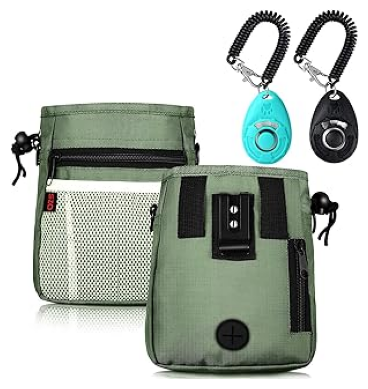

Image Index:  519
Predict:  piercino powder - 1.5 x 10 multi-sensory foodstuffs
True: careall triple antibiotic ointment 0.9 gr foil packet


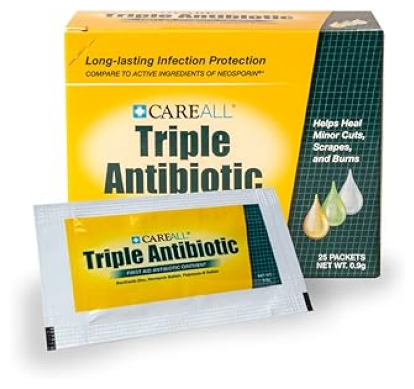

Image Index:  108
Predict:  jialto jiu-juice waffle maker 4 inch stainless steel 0.
True: kitchengenixs mini waffle maker 4 inch- 350 watts stainless steel non-


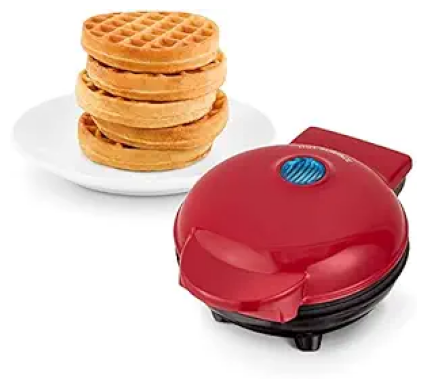

Image Index:  305
Predict:   stationery paper and envelopes set for writing letters in watercolor or plexiglass sets
True: personalized stationery flat notecards wenvelopes - monogram flat cards and envelop


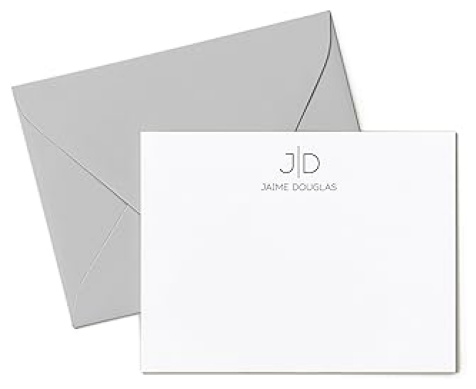

Image Index:  519
Predict:  piercito full size pomade powder - 1.5 3 x 5 heavy duty
True: careall triple antibiotic ointment 0.9 gr foil packet


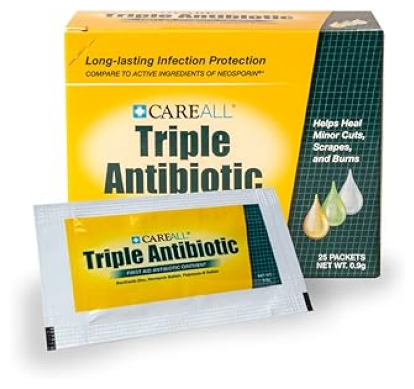

Image Index:  203
Predict:  tawolf roarsolote vision board game in-warlotc.
True: sharkool remote control car 2.4 ghz mini rc cars with rechargeable battery


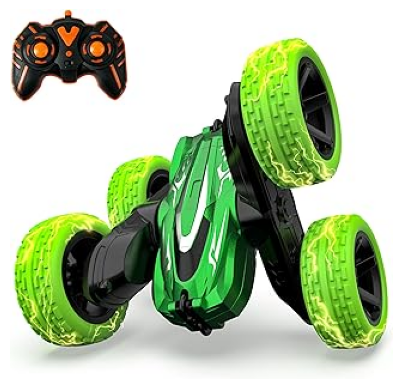

Image Index:  156
Predict:  gma mens slip on casual shoes breathable softwares pass-on fashion sneaker
True: hey dude womens wendy canvas womens shoes womens lace up loafers comfortable light


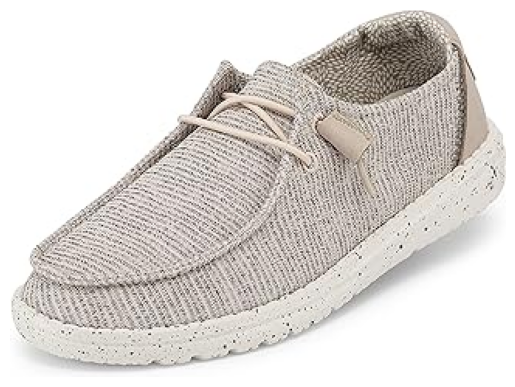

Image Index:  382
Predict:  hzman wrap bracelets men women man biker jacket and scarf hat red hazier wind
True: hzman wrap bracelets men women


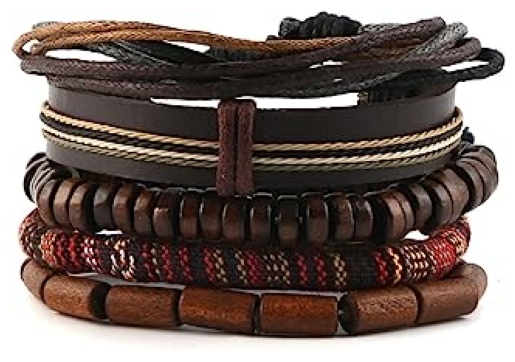

Image Index:  165
Predict:  a war too far a vietnam War novel that changed the way you think about warfare and
True: a war too far a vietnam war novel


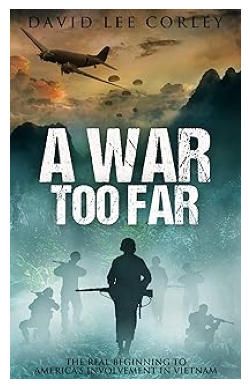

Image Index:  552
Predict:  2.5-pack for 1 pack of 2 liters iced window decorations decoration ceiling decor
True: dazzle bright curtain string lights


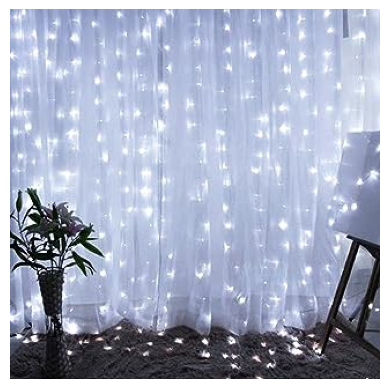

Image Index:  543
Predict:  The good news club size chart for adult women's skin care oil, 20 pcs.
True: susan bates 14099 knit-chek for knitting needle


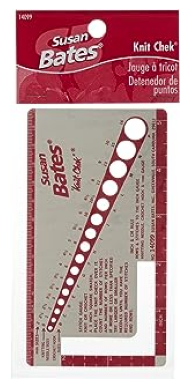

Image Index:  0
Predict:  restaurant all-round portable computer power machine with push button switches and magnets - repack
True: prestige psmfb 800 watt sandwich toaster with fixed plates


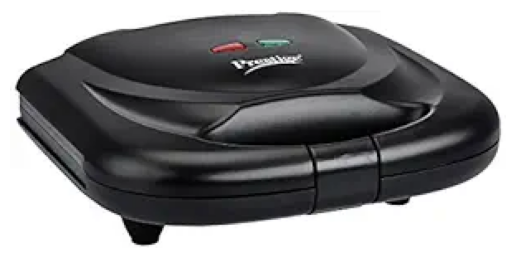

Image Index:  331
Predict:  tcl 65-inch qled 4 k led smart tv with google TV dolby t
True: tcl 65-inch q7 qled 4 k smart tv with google tv dolby


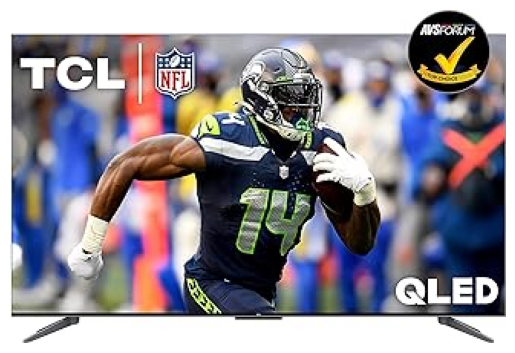

Image Index:  500
Predict:  shoey exercise dvd workstations for people with moderate to severe sleep apnea e
True: exercise for seniors dvd collection- 6 total body workouts 10 balance workouts resistance band 3 bonus


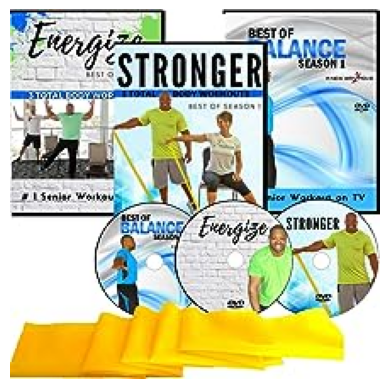

Image Index:  19
Predict:  amazonbasics double braided nylon usb c to lightning cable 3 w type-c fast charging
True: amazonbasics double braided nylon usb type-c to type-c 2.0 cable


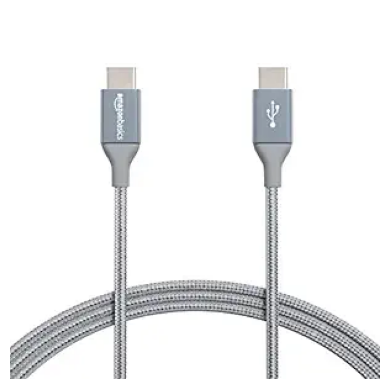

Image Index:  114
Predict:  acer aspire 15.
True: acer aspire 3 a315-24 p-r7 vh slim laptop 15.6 full


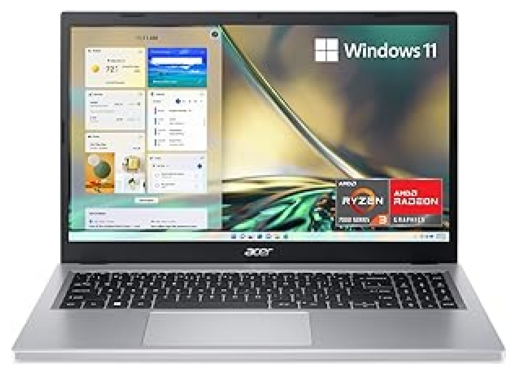

Image Index:  371
Predict:  eaula womens maternity pants with pockets stretch leggings and zip-up sweatshirt
True: amposh womens maternity pants stretchy lounge workout pants casual loose comfy pregnancy joggers with


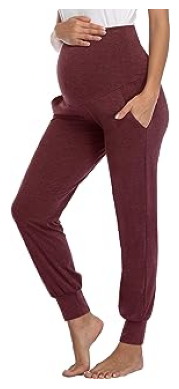

Image Index:  314
Predict:  inspiring vases for re-gown old pcs rained with blue and white yarn
True: caydo 200 pcs pipe cleaners craft supplies multi-color chenille stems for art


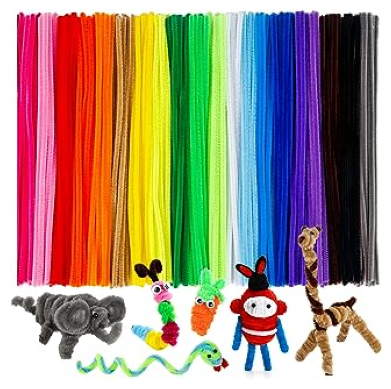

Image Index:  245
Predict:  sputters with a jiu-folds for swimming pool fun to use musical instruments in
True: 6 pcs wood egg shakers set


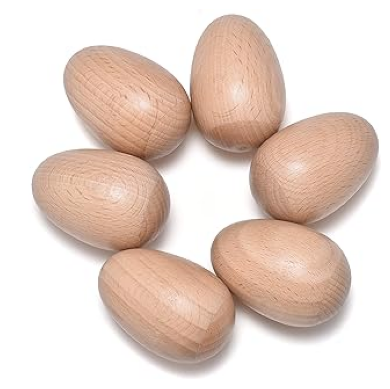

Image Index:  59
Predict:  wayona usb type c 65 w 6 ft 2 m fast charging cable compatible for iphone
True: wayona usb c 65 w fast charging cable compatible for tablets samsung s22 s20 s


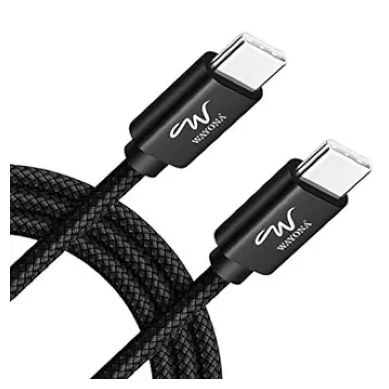

In [ ]:
import random

for i in range(20):
    rand_idx = random.randint(0, len(testset) - 1)
    img, true_text, _ = testset[rand_idx]


    img_tensor = image_processor(img, return_tensors="pt").pixel_values[0]
    text = generate_text(model, img_tensor)
    print("Image Index: ", rand_idx)
    print("Predict: ", text)
    print("True:", tokenizer.decode(true_text, skip_special_tokens=True))

    plt.imshow(img); plt.axis('off');plt.show()

### **Validation**

**Load Previous Model**

In [ ]:
run = wandb.init()
artifact = run.use_artifact('hungchiehwu/ConvNEXT-OPT-125m-amazon-name-v4/model-1xzkjuw6:v0', type='model')
artifact_dir = artifact.download()

model = ImageCaptioner(convNext_model, opt_model, tokenizer, 0)
checkpoint = torch.load(f"{artifact_dir}/model.ckpt")
model.load_state_dict(checkpoint["state_dict"])

##### **Inference Comparison**

In [22]:
!wget --no-cache -q -O selected_images.zip https://github.com/littlehongman/Comp576-Group41-Image-Captioning/raw/main/selected_images.zip

!unzip -qq selected_images.zip

Predict:  jbl tune wireless over ear bluetooth headphones with mic for 1.6 n on ps4


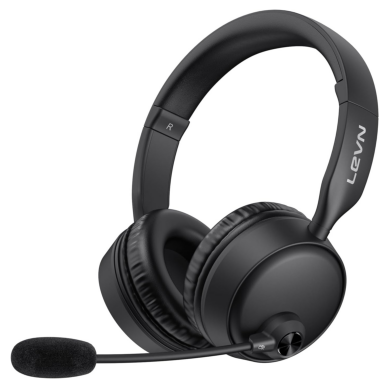

Predict:  kent-dried glasseria alkaline water filter with stainless steel handle. 50 w


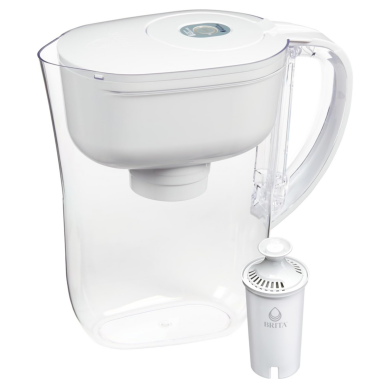

Predict:  hanes ecosmart long-sleeve fleece hoodie short sleeve pullover mens


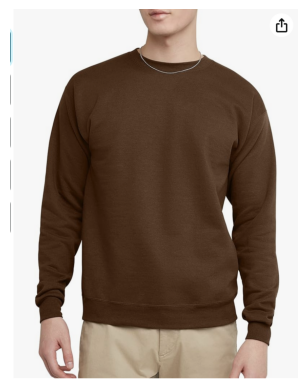

Predict:  leptal food bag with high-capacity transportation round flagellate primary car valence


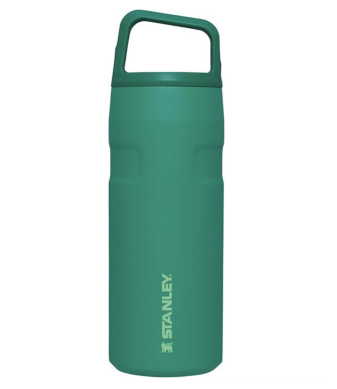

Predict:  bseash travel backpack with usb charging port for men and women size 12.


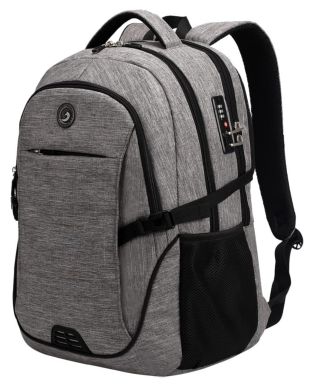

Predict:  jblox lite 2 w vr bluetooth 3.


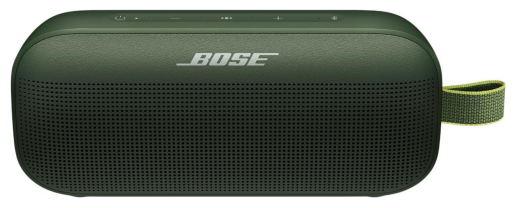

Predict:  Wisto 25 x 10 inch non-woven cloths self adhesive gels for food


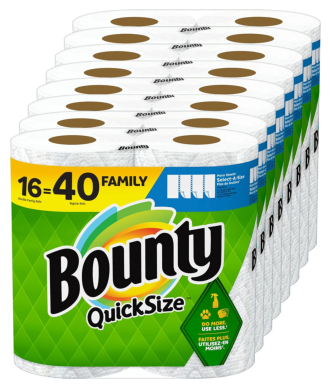

Predict:  sweets powder coca-coke oil pods 100 x 10 m2.


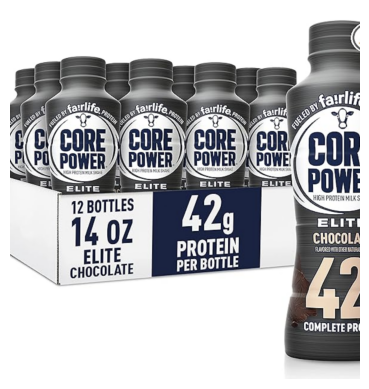

Predict:  gift replacement for the age-related problem - gout positive liquid formula with 1.5


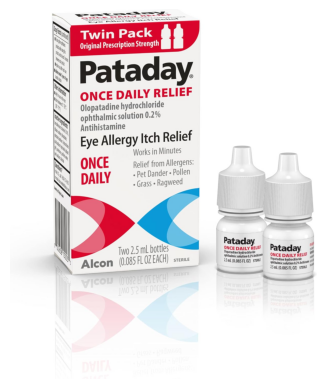

Predict:  leisure controller - connected to the home button with a wadgetrong d-pad


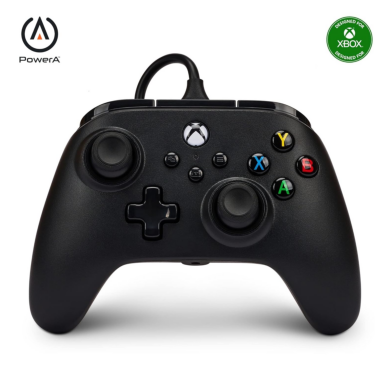

In [23]:
import os

image_dir = 'selected_images'

for filename in os.listdir(image_dir):

    if filename[-3:] in ['jpg', 'png'] or filename[-4:] in ['jpeg']:
        img = Image.open(os.path.join(image_dir, filename)).convert("RGB")


        img_tensor = image_processor(img, return_tensors="pt").pixel_values[0]
        text = generate_text(model, img_tensor)

        print("Predict: ", text)

        plt.imshow(img); plt.axis('off');plt.show()

 ##### **Calculate Metrics**

In [24]:
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics import BLEUScore
import evaluate
from tqdm import tqdm

def calculate_metrics(model, testset):
    model = model.to(device)

    #metrics
    total_rouge_scores = 0.0
    total_meteor_scores = 0.0
    total_bleu_scores = 0.0

    rouge = ROUGEScore()
    bleu = BLEUScore(n_gram=1)
    meteor = evaluate.load('meteor')

    for i in tqdm(range(len(testset))):
      img, reference, _ = testset[i]

      img_tensor = image_processor(img, return_tensors="pt").pixel_values[0].to(device)

      text = generate_text(model, img_tensor)
      reference = tokenizer.decode(reference, skip_special_tokens=True)

      total_rouge_scores += rouge(text, reference)['rougeL_fmeasure'].item()
      total_meteor_scores += meteor.compute(predictions=[text], references=[reference])['meteor']
      total_bleu_scores += bleu([text], [[reference]])

      # print(text, reference)


    print("\nRouge Score: {:.2f} Meteor Score: {:.2f} Bleu Score: {:.2f}".format(total_rouge_scores / len(testset) * 100, total_meteor_scores / len(testset) * 100, total_bleu_scores / len(testset) * 100))

In [25]:
calculate_metrics(model, testset)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 600/600 [03:04<00:00,  3.24it/s]


Rouge Score: 27.94 Meteor Score: 29.97 Bleu Score: 25.08


### **Save Model**

In [ ]:
wandb.finish()